In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import datetime
import math
import re
from plot_utility import create_football_field, get_dx_dy, show_play
from string import punctuation

In [2]:
plt.style.use('seaborn')
sns.despine()
sns.set_style("whitegrid", {'axes.grid' : False})

<Figure size 576x396 with 0 Axes>

# Load Data

In [3]:
%%time
train_df = pd.read_csv('train.csv', low_memory=False)
train_df.shape

CPU times: user 3.65 s, sys: 555 ms, total: 4.2 s
Wall time: 4.23 s


(509762, 49)

# Data Types
Breakdown columns into numerical/categorical.

In [4]:
train_df.dtypes.value_counts()

object     24
int64      15
float64    10
dtype: int64

In [5]:
train_df.dtypes.sort_values()

GameId                      int64
Yards                       int64
Week                        int64
NflIdRusher                 int64
VisitorScoreBeforePlay      int64
HomeScoreBeforePlay         int64
Distance                    int64
Down                        int64
Quarter                     int64
YardLine                    int64
Season                      int64
JerseyNumber                int64
PlayerWeight                int64
NflId                       int64
PlayId                      int64
Humidity                  float64
DefendersInTheBox         float64
Temperature               float64
Y                         float64
S                         float64
X                         float64
A                         float64
Dis                       float64
Orientation               float64
Dir                       float64
Turf                       object
Location                   object
Stadium                    object
PlayerCollegeName          object
VisitorTeamAbb

* PlayerHeight should be converted to numerical value(int64).
* PlayerAge(int64) should be derived from PlayerBirthDate.
* GameClock should be converted to numerical value(int64).

In [6]:
train_df.select_dtypes(include='object').nunique().sort_values(ascending = False)

TimeSnap             22943
TimeHandoff          22935
DisplayName           2230
PlayerBirthDate       1688
GameClock              901
PlayerCollegeName      301
GameWeather             61
Location                60
OffensePersonnel        56
Stadium                 55
WindDirection           53
WindSpeed               40
DefensePersonnel        38
PossessionTeam          32
HomeTeamAbbr            32
VisitorTeamAbbr         32
FieldPosition           32
StadiumType             29
Position                25
Turf                    20
PlayerHeight            16
OffenseFormation         8
PlayDirection            2
Team                     2
dtype: int64

# Weather

In [7]:
print(pd.Series(train_df["GameWeather"].unique()).sort_values().to_string())

19                                   30% Chance of Rain
5                                                 Clear
53                                          Clear Skies
49                                       Clear and Cool
47                                      Clear and Sunny
59                                       Clear and cold
42                                      Clear and sunny
0                                        Clear and warm
27                                          Clear skies
12                                               Cloudy
39                                      Cloudy and Cool
35                                      Cloudy and cold
20    Cloudy with periods of rain, thunder possible....
46                           Cloudy, 50% change of rain
57                                         Cloudy, Rain
31                               Cloudy, chance of rain
22        Cloudy, fog started developing in 2nd quarter
34                 Cloudy, light snow accumulati

# High Cardinality >100
* TimeSnap/TimeHandoff will not be used directly. They can be used to derive features like date, hourofday etc.
* DisplayName will be dropped.
* PlayerBirthDate will be converted to numeric.
* GameClock will be converted to numeric.
* PlayerCollegeName will be dropped.   

# Medium Cardinality <100, >10
* Merge values which are highly correlated into new groups to reduce cardinality.

# Low Cardinality
* One hot encode these features.

# Target Variable

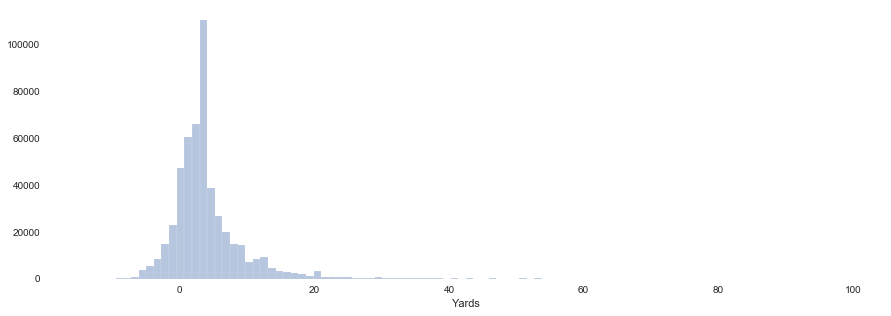

In [8]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.distplot(train_df["Yards"], bins = 100, kde = False, ax = ax)
plt.show()

In [9]:
train_df["Yards"].describe()

count    509762.000000
mean          4.212334
std           6.436167
min         -14.000000
25%           1.000000
50%           3.000000
75%           6.000000
max          99.000000
Name: Yards, dtype: float64

Yards can theoretically range from -99 to 99. Depending on where on the field the play starts the probability of some yards are not possible.   
Example: If the team is 10 yards from the opponents endzone area, the possible range of yards is [-90, 10].

To get consistency it would be good if offensive team is always moving in the same direction. Let's standardize so they always move left to right.

# Preprocessing

# HomeTeamAbbr/VisitorTeamAbbr

In [10]:
#changing team abbr such that every team only has one unique abbr in the data
train_df.loc[train_df.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
train_df.loc[train_df.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"

train_df.loc[train_df.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
train_df.loc[train_df.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"

train_df.loc[train_df.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
train_df.loc[train_df.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"

train_df.loc[train_df.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
train_df.loc[train_df.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"

# Stadium

In [11]:
#clean Stadium column
map_stad = {'Broncos Stadium at Mile High': 'Broncos Stadium At Mile High',
            'CenturyField': 'CenturyLink Field',
            'CenturyLink': 'CenturyLink Field',
            'Everbank Field': 'EverBank Field',
            'FirstEnergy': 'First Energy Stadium',
            'FirstEnergy Stadium': 'First Energy Stadium',
            'FirstEnergyStadium': 'First Energy Stadium',
            'Lambeau field': 'Lambeau Field',
            'Los Angeles Memorial Coliesum': 'Los Angeles Memorial Coliseum',
            'M & T Bank Stadium': 'M&T Bank Stadium',
            'M&T Stadium': 'M&T Bank Stadium',
            'Mercedes-Benz Dome': 'Mercedes-Benz Superdome',
            'MetLife': 'MetLife Stadium',
            'Metlife Stadium': 'MetLife Stadium',
            'NRG': 'NRG Stadium',
            'Oakland Alameda-County Coliseum': 'Oakland-Alameda County Coliseum',
            'Paul Brown Stdium': 'Paul Brown Stadium',
            'Twickenham': 'Twickenham Stadium'}
    
for stad in train_df['Stadium'].unique():
    if stad in map_stad.keys():
        pass
    else:
        map_stad[stad]=stad

train_df["Stadium"] = train_df['Stadium'].map(map_stad)

# Stadium Type

The following stadiums have NaN values.   
- MetLife Stadium   
- StubHub Center   
- TIAA Bank Field

In [12]:
train_df.groupby("Stadium").agg({"StadiumType": "unique"})

,StadiumType
Stadium,
AT&T Stadium,"[Indoor, Outdoors, Outdoor, Indoors]"
Arrowhead Stadium,[Outdoor]
Bank of America Stadium,[Outdoors]
Broncos Stadium At Mile High,[Outdoor]
CenturyLink Field,[Outdoor]
Estadio Azteca,[Outdoor]
EverBank Field,[Open]
FedExField,"[Outdoors, Outdoor]"
First Energy Stadium,[Outdoor]


# Turf

In [13]:
Turf = {'Field Turf':'Artificial',
        'A-Turf Titan':'Artificial',
        'Grass':'Natural',
        'UBU Sports Speed S5-M':'Artificial',
        'Artificial':'Artificial',
        'DD GrassMaster':'Artificial',
        'Natural Grass':'Natural',
        'UBU Speed Series-S5-M':'Artificial',
        'FieldTurf':'Artificial',
        'FieldTurf 360':'Artificial',
        'Natural grass':'Natural',
        'grass':'Natural',
        'Natural':'Natural',
        'Artifical':'Artificial',
        'FieldTurf360':'Artificial',
        'Naturall Grass':'Natural',
        'Field turf':'Artificial',
        'SISGrass':'Artificial',
        'Twenty-Four/Seven Turf':'Artificial',
        'natural grass':'Natural'}

train_df['Turf'] = train_df['Turf'].map(Turf)

# Player Height

In [14]:
#convert from feet+inches to inches
train_df['PlayerHeight'] = train_df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

# Player Age

In [15]:
#compute player age as time between birthdate and timesnap
train_df["PlayerAge"] = np.rint(((pd.to_datetime(train_df["TimeSnap"], format='%Y/%m/%d').dt.date -
                        pd.to_datetime(train_df["PlayerBirthDate"], format='%m/%d/%Y').dt.date)).dt.days / 365).astype("int")

# Game Clock

In [16]:
#convert gameclock to timeleft of quarter
train_df["GameClock"] = train_df["GameClock"].apply(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1]))

In [17]:
train_df.select_dtypes(include='object').nunique().sort_values(ascending = False)

TimeSnap             22943
TimeHandoff          22935
DisplayName           2230
PlayerBirthDate       1688
PlayerCollegeName      301
GameWeather             61
Location                60
OffensePersonnel        56
WindDirection           53
WindSpeed               40
DefensePersonnel        38
Stadium                 37
HomeTeamAbbr            32
VisitorTeamAbbr         32
FieldPosition           32
PossessionTeam          32
StadiumType             29
Position                25
OffenseFormation         8
PlayDirection            2
Turf                     2
Team                     2
dtype: int64

# Standardizing play direction.
Process such that the team on offense always moves from left(x=0) to right(x=100).   
Standardize directions
0 <= Dir_std <= 360   

All plays move from left to right.   
0 degrees: Straight towards enemy touchdown zone   
90 degrees: player moving to his left   
180 degrees: player moving backwards   
270 degrees: player moving to his right 

In [18]:
#create dummy cols for offensive team(home/away) and side of the field(home/away)
train_df["TeamOnOffense"] = np.where(train_df["PossessionTeam"] == train_df["HomeTeamAbbr"], "home", "away")
train_df["FieldPositionTeam"] = np.where(train_df["FieldPosition"] == train_df["HomeTeamAbbr"], "home", "away")

In [19]:
#create column for yards from own goal (for the offensive team in the play)
train_df["YardLine_std"] = np.where(train_df["TeamOnOffense"] == train_df["FieldPositionTeam"],
                                    train_df["YardLine"], 100 - train_df["YardLine"])

In [20]:
#dummy column IsOnOffense for each individual player
train_df['IsOnOffense'] = train_df.Team == train_df.TeamOnOffense # Is player on offense?

In [21]:
#mirror X, Y coordinates for plays going to left 
train_df['X_std'] = np.where(train_df["PlayDirection"] == "left", 120 - train_df.X, train_df.X)
train_df['Y_std'] = np.where(train_df["PlayDirection"] == "left", 160/3 - train_df.Y, train_df.Y)

In [22]:
"""
standardize directions.
0 <= Dir_std <= 360

All plays move from left to right.
0 degrees: Straight towards enemy touchdown zone
90 degrees: player moving to his left
180 degrees: player moving backwards
270 degrees: player moving to his right
"""
train_df["Dir_std"] = np.where(train_df["PlayDirection"] == "left", 270 - train_df["Dir"], 90 - train_df["Dir"])
train_df["Dir_std"] = np.where(train_df["Dir_std"] < 0, train_df["Dir_std"] + 360, train_df["Dir_std"])

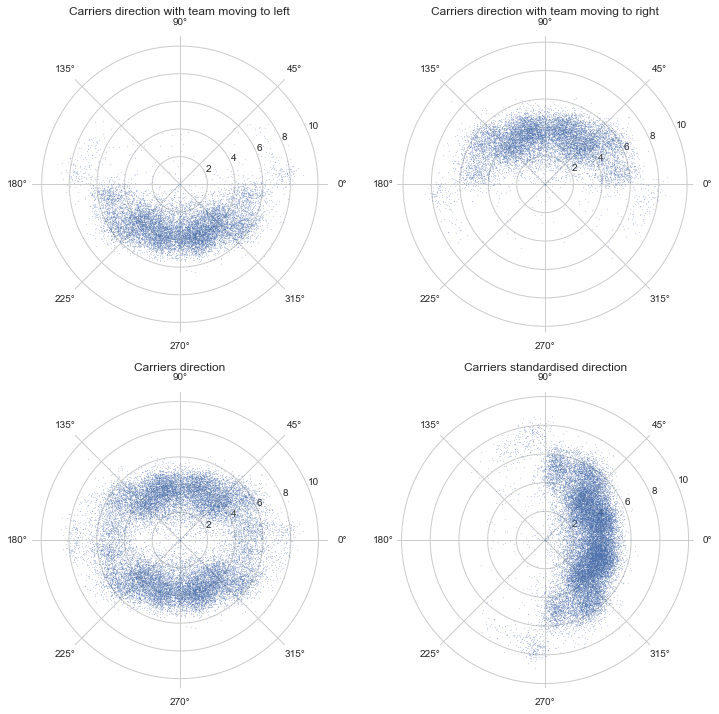

In [23]:
plt.figure(figsize=(12, 12))
ax = plt.subplot(221, projection='polar')
df = train_df[(train_df.PlayDirection == "left") & (train_df.NflIdRusher == train_df.NflId) & (train_df.IsOnOffense)]
ax.set_title('Carriers direction with team moving to left')
ax.scatter(df.Dir * np.pi/180, df.S, s=1, alpha=0.2)

ax = plt.subplot(222, projection='polar')
df = train_df[(train_df.PlayDirection == "right") & (train_df.NflIdRusher == train_df.NflId) & (train_df.IsOnOffense)]
ax.set_title('Carriers direction with team moving to right')
ax.scatter(df.Dir * np.pi/180, df.S, s=1, alpha=0.2)

ax = plt.subplot(223, projection='polar')
df = train_df[(train_df.IsOnOffense) & (train_df.NflIdRusher == train_df.NflId)]
ax.set_title('Carriers direction')
ax.scatter(df.Dir * np.pi/180, df.S, s=1, alpha=0.2)

ax = plt.subplot(224, projection='polar')
df = train_df[(train_df.IsOnOffense) & (train_df.NflIdRusher == train_df.NflId)]
ax.set_title('Carriers standardised direction')
ax.scatter(df.Dir_std * np.pi/180, df.S, s=1, alpha=0.2)
plt.show()

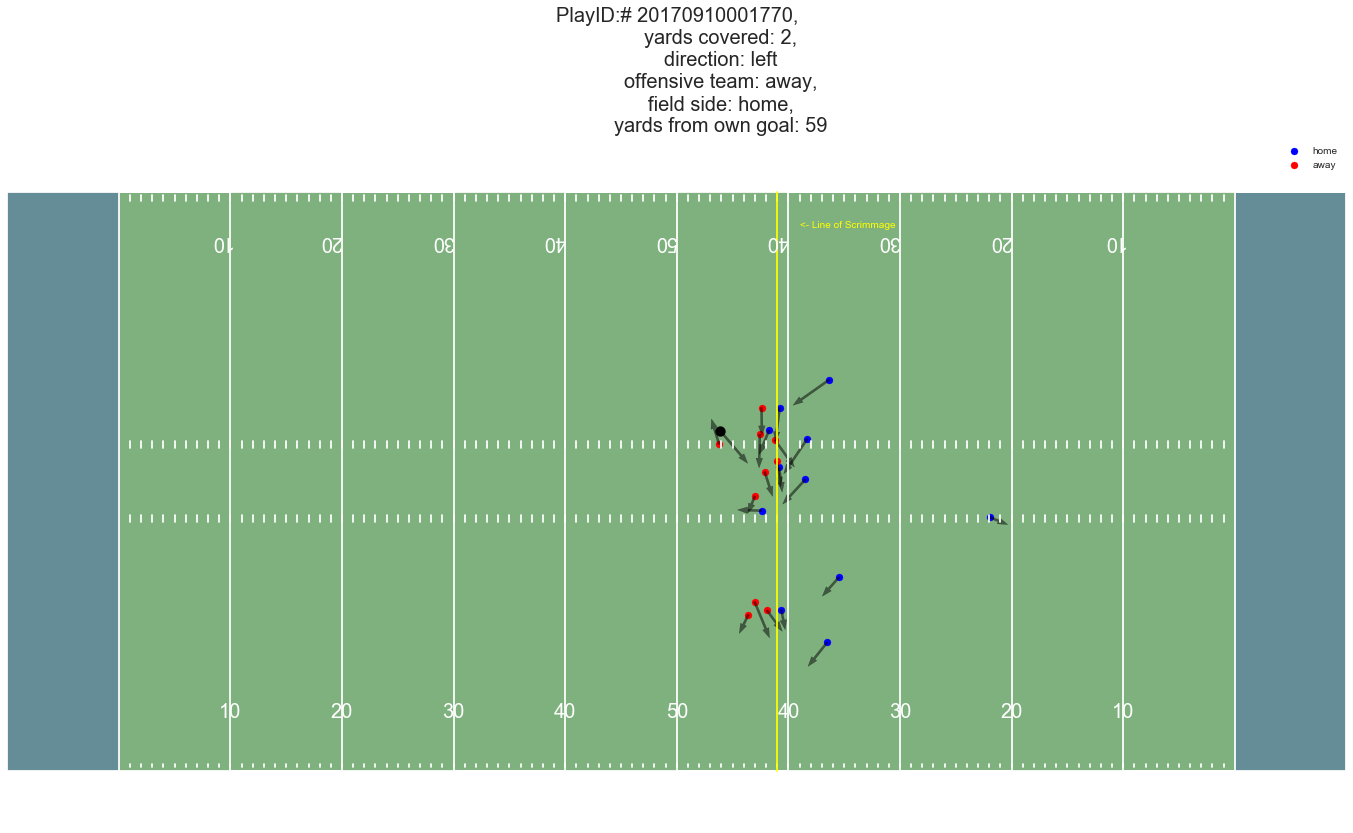

In [24]:
show_play(20170910001770, train_df)